# Introduction
In this exercise, we're going to do Natural Language Processing (NLP) regarding disaster tweets. The data used for this is retrieved at the following [link](https://www.kaggle.com/c/nlp-getting-started/overview). 

In [54]:
# Install wordcloud and keras if you haven't already
!pip install wordcloud
!pip install keras
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=69b85c8958cff4bb9daa2b26b73b64903eea67dd217a243fee57b6ab670a49ea
  Stored in directory: c:\users\ardejong\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [111]:
# Importing the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize.regexp import regexp_tokenize
from langdetect import detect
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from wordcloud import WordCloud
import scipy.stats as stats
import random
import re
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

# Data preparation
In this chapter, the data will be imported and cleaned to make it ready for our data analysis

## Data import

In [3]:
# Import the data using pandas
trainset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

trainset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Cleaning
In this paragraph, we'll clean the two datasets. We'll do that by performing the next steps:
- Dealing with null values
- Cleaning text for keyword and location column
- Cleaning text data (remove url, HTMLs, emojies, hastags)
- Remove unnecessary features

In [4]:
# Check the datasets using the info method
display(trainset.info())
display(testset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

### Dealing with null values

In [5]:
print(f"Null values per column for the train set :\n{trainset.isnull().sum()}")
print(f"Null values per column for the test set:\n{testset.isnull().sum()}")

Null values per column for the train set :
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null values per column for the test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


In [6]:
# Check percentage of null values per column for both datasets
print(f"Null values percentage per column for the train set :\n{trainset.isnull().sum() / trainset.shape[0]}")
print(f"Null values percentage per column for the test set:\n{testset.isnull().sum() / testset.shape[0]}")

Null values percentage per column for the train set :
id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64
Null values percentage per column for the test set:
id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64


What we see here is that for both train and test set, there are two columns with null values: `location` and `keyword`. For the location column, around 1/3th of the column has no values, whilst the keyword column only has about 0.8 percent of missing data. Since their're both text columns with lots of variety, the best way to deal with the null values, is to use the backward and forward fill method, which fills the null value with the next and previous non-null value.

In [7]:
# Fill the na values with the bfill method
trainset = trainset.bfill(axis = 'rows')
testset = testset.bfill(axis = 'rows')

# Fill the na values with the ffill method
trainset = trainset.ffill(axis = 'rows')
testset = testset.ffill(axis = 'rows')

# Print the null values per column to see if the fill method worked
print(f"Null values per column for the train set :\n{trainset.isnull().sum()}")
print(f"Null values per column for the test set:\n{testset.isnull().sum()}")

Null values per column for the train set :
id          0
keyword     0
location    0
text        0
target      0
dtype: int64
Null values per column for the test set:
id          0
keyword     0
location    0
text        0
dtype: int64


### Cleaning text for keyword and location column

In [8]:
# Create a function that clean the text columns: clean_text
def clean_text(series):
    # Lower to lowercase for each word
    series = series.apply(lambda x: x.lower())
    
    # Remove numbers
    pattern = r"[0-9]"
    series = series.apply(lambda x: re.sub(pattern, ' ', x))
    
    # Remove special character
    pattern = r"[^a-zA-Z0-9]"
    series = series.apply(lambda x: re.sub(pattern, ' ', x))
    
    # Remove URLs
    pattern = r'http\S+'
    series = series.apply(lambda x: re.sub(pattern, ' ', x))
    
    # Remove emojies
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    series = series.apply(lambda x: emoji_pattern.sub(r' emoji ', x))
    
    return series

In [9]:
# Apply clean_data function to the keyword and location columns
columns = ['keyword', 'location', 'text']
trainset[columns] = trainset[columns].apply(lambda x: clean_text(x))
testset[columns] = testset[columns].apply(lambda x: clean_text(x))

trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Remove unnecesarry features
In this paragraph, we'll remove unnecesarry features from our dataset. This will be the `id` column

In [10]:
trainset_clean = trainset.drop('id', axis = 1)
testset_clean = testset.drop('id', axis = 1)
trainset_clean.head()

,keyword,location,text,target
0,ablaze,birmingham,our deeds are the reason of this earthquake m...,1
1,ablaze,birmingham,forest fire near la ronge sask canada,1
2,ablaze,birmingham,all residents asked to shelter in place are ...,1
3,ablaze,birmingham,people receive wildfires evacuation or...,1
4,ablaze,birmingham,just got sent this photo from ruby alaska as ...,1


## Creating new features
In this paragraph, we'll add new features to the dataset. This is done in order to increase the input for the model training and testing. We'll add the following features:
- Number of tokens used in tweet: n_tokens
- Language of the tweet: language

### Number of tokens used in tweet: n_tokens

In [11]:
# Create n_tokens feature using regex
trainset_clean['n_tokens'] = [len(regexp_tokenize(line, '\w+')) for line in trainset_clean.text]
testset_clean['n_tokens'] = [len(regexp_tokenize(line, '\w+')) for line in testset_clean.text]

trainset_clean.head()

,keyword,location,text,target,n_tokens
0,ablaze,birmingham,our deeds are the reason of this earthquake m...,1,13
1,ablaze,birmingham,forest fire near la ronge sask canada,1,7
2,ablaze,birmingham,all residents asked to shelter in place are ...,1,22
3,ablaze,birmingham,people receive wildfires evacuation or...,1,7
4,ablaze,birmingham,just got sent this photo from ruby alaska as ...,1,16


### Language of the tweet: language

In [12]:
# Create function for creating language features
def language(series):
# Create empty list: languages
    languages = []
    
# Detect the langauge of each review using detect
    for i in series:
        lang = detect(i)
        languages.append(lang)
    
    return languages

In [13]:
trainset_clean['language'] = language(trainset_clean.text)
testset_clean['language'] = language(testset_clean.text)
testset_clean.head()

,keyword,location,text,n_tokens,language
0,ablaze,london,just happened a terrible car crash,6,en
1,ablaze,london,heard about earthquake is different cities s...,9,en
2,ablaze,london,there is a forest fire at spot pond geese are...,19,en
3,ablaze,london,apocalypse lighting spokane wildfires,4,en
4,ablaze,london,typhoon soudelor kills in china and taiwan,7,en


### Length of keyword: len_keyword

In [14]:
# Create column that takes the length of each keyword: len_keyword
trainset_clean["len_keyword"] = trainset_clean.keyword.apply(lambda x: len(x))
testset_clean["len_keyword"] = testset_clean.keyword.apply(lambda x: len(x))

## Vectorizer 
In this paragraph, we'll vectorize the `text` column of the datasets. This will be done using a TfidfVectorizer.

In [64]:
# Create function that creates a TfidfVectorizer and returns 
def vectorize(datasets, stop_words, max_features):
    # Set train and test set based on datasets parameter
    train = datasets[0]
    test = datasets[1]
    
    # Initialize the vectorizer
    vect = TfidfVectorizer(stop_words = stop_words, 
                           max_features = max_features)
    
    # Create the vector for the train and test set
    tfidf_train = vect.fit_transform(train)
    tfidf_test = vect.transform(test)
    
    # Create dataframes based on vectors 
    train_df = pd.DataFrame(tfidf_train.A, columns = vect.get_feature_names())
    test_df = pd.DataFrame(tfidf_test.A, columns = vect.get_feature_names())
    
    return (train_df, test_df)

In [82]:
# Set up parameters
stop_words = ['english', 'german', 'french', 'spanish', 'portuguese', 'polish', 'italian']
max_features = 1000
datasets = [trainset_clean.text, testset_clean.text]

# Call vectorize function to vectorize train and test set
train, test = vectorize(datasets, stop_words, max_features)


# Add the remaining column to the train and test set
cols = ['keyword', 'location', 'n_tokens', 'language', 'len_keyword']
train[cols] = trainset_clean[cols]
test[cols] = testset_clean[cols]

display(train.head())
display(test.head())

,abc,ablaze,about,accident,across,action,actually,added,affected,after,...,yourself,youth,youtube,yr,zone,keyword,location,n_tokens,language,len_keyword
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,birmingham,13,en,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,birmingham,7,no,6
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,birmingham,22,en,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,birmingham,7,en,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,birmingham,16,en,6


,abc,ablaze,about,accident,across,action,actually,added,affected,after,...,yourself,youth,youtube,yr,zone,keyword,location,n_tokens,language,len_keyword
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,london,6,en,6
1,0.0,0.0,0.339124,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,london,9,en,6
2,0.0,0.0,0.000000,0.0,0.370473,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,london,19,en,6
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,london,4,en,6
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,ablaze,london,7,en,6


# Data analysis
In this chapter, some data analysis will be performed. We'll do that by creating multiple visualizations that enhance our data story with information. We'll also perform multiple hypothesis tests to find possible relationships within the datasets.

## Data visualization
Things to explore:
- distribution of targets
- distribution of languages
- 10 most common locations per target
- word cloud of keywords per target 
- distribution of n_tokens

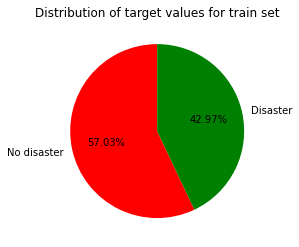

In [83]:
# Find the distribution of the target types
data_train = trainset_clean.target.value_counts(normalize = True)

plt.pie(x = data_train, labels = ["No disaster", "Disaster"], colors = ['red', 'green'],
       autopct = "%0.2f%%", startangle = 90)
plt.title("Distribution of target values for train set")
plt.show()

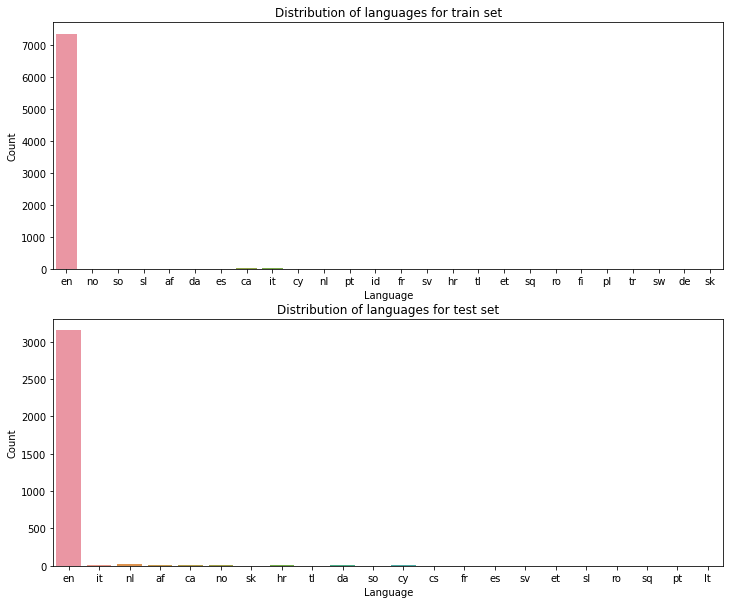

In [84]:
# Find the distribution of languages for train and testset
# Set parameters
datasets = [trainset_clean, testset_clean]
titles = ["Distribution of languages for train set", "Distribution of languages for test set"]

# Create subplots
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2)

for title, data, axes in zip(titles, datasets, ax.flat):
    sns.countplot(x = 'language', data = data, ax = axes)
    axes.set_xlabel("Language")
    axes.set_ylabel("Count")
    axes.set_title(title)
    
plt.show()

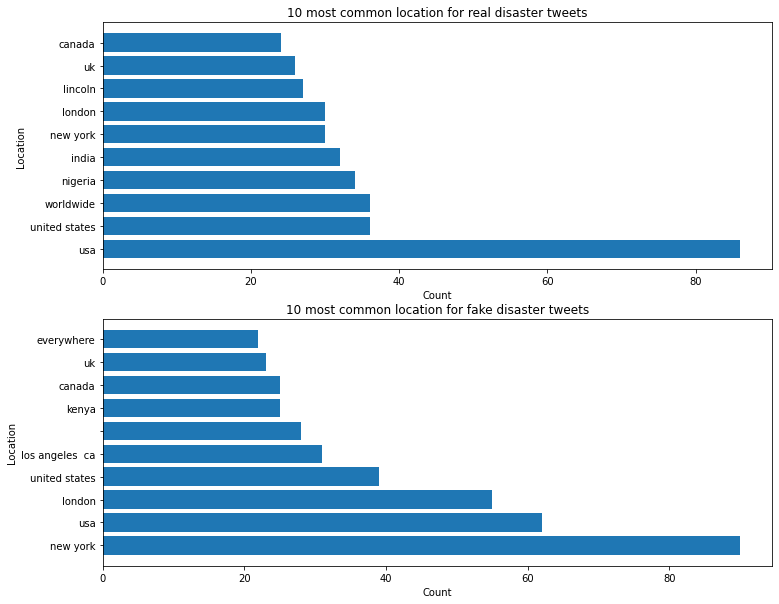

In [85]:
# Find 10 most common locations per target value
disaster = trainset_clean.loc[trainset_clean.target == 1, :]
no_disaster = trainset_clean.loc[trainset_clean.target == 0, :]

data_disaster = disaster.location.value_counts().sort_values(ascending = False)[:10]
data_no_disaster = no_disaster.location.value_counts().sort_values(ascending = False)[:10]

# Set up parameters for plotting
datasets = [data_disaster, data_no_disaster]
titles = [f"{len(data_disaster)} most common location for real disaster tweets", 
          f"{len(data_no_disaster)} most common location for fake disaster tweets"]

fig, ax = plt.subplots(figsize = (12, 10), nrows = 2)

for data, title, axes in zip(datasets, titles, ax.flat):
    axes.barh(data.index.tolist(), data)
    axes.set_title(title)
    axes.set_ylabel("Location")
    axes.set_xlabel("Count")
plt.show()

### Word cloud of keywords per target

In [70]:
def wordcloud(data, title, ax):
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",
                           width = 400, height = 400, min_word_length = 3).generate(str(data))
    
    # Display the generated image:
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title, fontsize = 20)

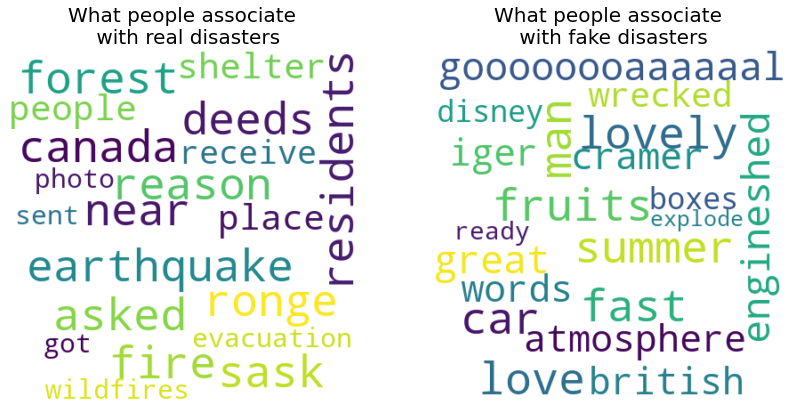

In [71]:
fig, ax = plt.subplots(ncols = 2, figsize = (14, 10))

wordcloud_true = wordcloud(disaster.text, "What people associate \n with real disasters", ax[0])
wordcloud_false = wordcloud(no_disaster.text, "What people associate \n with fake disasters", ax[1])

# Display the generated images
plt.show()

## Relationships between the data
Using hypothesis testing.
Possible relationships:
- N_tokens and target
- language and n_token
- language and target
- n_tokens and location

In [86]:
# Create a function that performs a hypothesis test: hypothesis_test
def hypothesis_test(data1, data2, test):
    stat, p = test(data1, data2)
    print(f"The p-value is: {p}")
    print(f"The test statistic comes out to be equal to: {stat}")

### N_tokens and target

In [88]:
# Set up parameters
data1 = disaster.n_tokens.sample(n = 100)
data2 = no_disaster.n_tokens.sample(n = 100)

# Call hypothesis_test to perform hypothesis testing
hypothesis_test(data1, data2, stats.ttest_ind)

The p-value is: 0.6793913556076558
The test statistic comes out to be equal to: 0.41390543738074653


### Language and target

In [87]:
# Set up parameters
sample = 100

data1 = np.where(disaster.language == 'en', 1, 0)
data2 = np.where(no_disaster.language == 'en', 1, 0)

sample1 = np.random.choice(data1, sample)
sample2 = np.random.choice(data2, sample)

# Call hypothesis_test to perform hypothesis testing
hypothesis_test(sample1, sample2, stats.ttest_ind)

The p-value is: 0.12216453288455022
The test statistic comes out to be equal to: 1.5523955167133086


### Language and n_tokens

In [89]:
# Set up parameters
sample = 100

data1 = trainset_clean.loc[trainset_clean.language == 'en', :]
data2 = trainset_clean.loc[trainset_clean.language != 'en', :]

sample1 = data1.n_tokens.sample(n = sample)
sample2 = data2.n_tokens.sample(n = sample)

# Call hypothesis_test to perform hypothesis testing
hypothesis_test(sample1, sample2, stats.ttest_ind)

The p-value is: 5.75094238304367e-24
The test statistic comes out to be equal to: 11.564037482751662


# Models
In this chapter, we'll use multiple models to train and test on a validation set of the data. For this, we'll use the following models:
- MultinomialNB
- Neural Network using keras
- Support Vector Machine

At first, we'll prepare the data so that it's ready for model training. Then, we'll instantiate and build the models. After that, each model gets trained and tested on the validation set.

## Data preperation
In this paragraph, we'll prepare the data for the model building.

In [91]:
# Convert the string columns location and keyword to numbers using LabelEncoderd
# Do this for both the train and test set
le = LabelEncoder()
train['keyword'], train['location'] = le.fit_transform(train.keyword), le.fit_transform(train.location)
test['keyword'], test['location'] = le.fit_transform(test.keyword), le.fit_transform(test.location)


# Convert the language column so that if it's English, it's 1, else 0
train['language'] = np.where(trainset_clean.language == 'en', 1, 0)

train.head()

,abc,ablaze,about,accident,across,action,actually,added,affected,after,...,yourself,youth,youtube,yr,zone,keyword,location,n_tokens,language,len_keyword
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,451,13,1,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,451,7,0,6
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,451,22,1,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,451,7,1,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,451,16,1,6


In [130]:
# Split the train data into train and validation set
y = trainset_clean.target.astype('category')
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.15, random_state = 42)

## Model building
In this paragraph, the models will be build.

In [149]:
# Instantiate the models
multinb = MultinomialNB()
svm = SVC()

# Set number of columns of X_train: n_cols
n_cols = X_train.shape[1]

# Create the keras model: nn
nn = Sequential()

# Add the first layer
nn.add(Dense(50, activation = "relu", input_shape = (n_cols,)))

# Add the second layer
nn.add(Dense(25, activation = "relu"))

# Add the output layer
nn.add(Dense(2, activation = 'softmax'))

## Model training
In this paragraph, we'll train on the train set for all models.

In [101]:
type(np.array(y_train))

numpy.ndarray

In [150]:
# Train on the MultinomialNB model
multinb.fit(X_train, y_train)

# Train on the SVC model
svm.fit(X_train, y_train)

# Train on the keras neural network
# Set parameters
predictors = X_train.values
target = to_categorical(y_train)
validate_pred = X_val.values
target_val = to_categorical(y_val)

nn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
nn.fit(predictors, target, epochs=15, batch_size=32, validation_data = (validate_pred, target_val))

Epoch 1/15
203/203 [==============================] - 1s 3ms/step - loss: 1.1740 - accuracy: 0.5514 - val_loss: 1.0570 - val_accuracy: 0.5709
Epoch 2/15
203/203 [==============================] - 0s 2ms/step - loss: 0.7350 - accuracy: 0.6032 - val_loss: 0.7033 - val_accuracy: 0.5105
Epoch 3/15
203/203 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.6294 - val_loss: 0.5806 - val_accuracy: 0.7644
Epoch 4/15
203/203 [==============================] - 0s 2ms/step - loss: 0.6714 - accuracy: 0.6523 - val_loss: 0.6589 - val_accuracy: 0.6515
Epoch 5/15
203/203 [==============================] - 0s 2ms/step - loss: 0.6344 - accuracy: 0.6775 - val_loss: 0.6507 - val_accuracy: 0.6673
Epoch 6/15
203/203 [==============================] - 0s 2ms/step - loss: 0.5953 - accuracy: 0.7045 - val_loss: 0.5432 - val_accuracy: 0.7539
Epoch 7/15
203/203 [==============================] - 0s 2ms/step - loss: 0.5729 - accuracy: 0.7242 - val_loss: 0.5356 - val_accuracy: 0.7496
Epoch 

## Model testing

In [116]:
# Define a function that takes the predicted and actual values
# and print/plots the results
def model_evaluation(true, pred, name):
    # Get the followings scores and print it:
    # Accuracy, precision, recall and f1 score
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    f1 = f1_score(true, pred)
    
    print(f"Accuracy of {name} model: {acc:.3f}")
    print(f"Precision score of {name} model: {prec:.3f}")    
    print(f"Recall score of {name} model: {rec:.3f}")
    print(f"F1 score of {name} model: {f1:.3f}")
    
    # Get the confusion matrix and plot it
    conf_matrix = confusion_matrix(true, pred)
    
    fig, ax = plt.subplots()
    sns.heatmap(conf_matrix, annot = True, cbar = False, 
                fmt = 'd', cmap = 'Blues', ax = ax, xticklabels = ["No disaster", "Disaster"],
               yticklabels = ["No disaster", "Disaster"])
    ax.set_xlabel("Predicted values")
    ax.set_ylabel("Actual values")
    ax.set_title(f"Confusion matrix of {name} model")
    plt.show()

Accuracy of MultinomialNB model: 0.608
Precision score of MultinomialNB model: 0.555
Recall score of MultinomialNB model: 0.560
F1 score of MultinomialNB model: 0.557


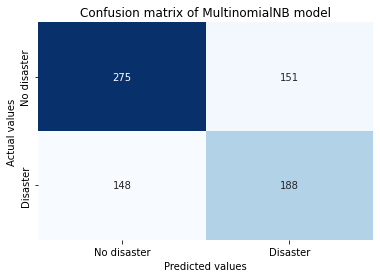

In [117]:
# Predict on the MultinomialNB model
pred_mul = multinb.predict(X_val)

# Call the model_evaluation function on the MultinomialNB model
name = "MultinomialNB"

model_evaluation(y_val, pred_mul, name)

Accuracy of Support Vector Machine model: 0.559
Precision score of Support Vector Machine model: 0.000
Recall score of Support Vector Machine model: 0.000
F1 score of Support Vector Machine model: 0.000


C:\Users\ardejong\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


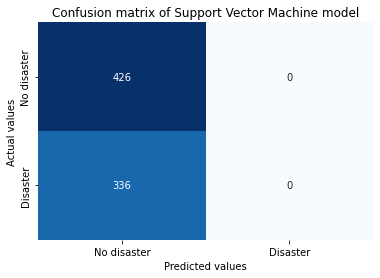

In [118]:
# Predict on the SVC model
pred_svm = svm.predict(X_val)

# Call the model_evaluation function on the MultinomialNB model
name = "Support Vector Machine"

model_evaluation(y_val, pred_svm, name)

In [153]:
# Set parameters for predicting on the neural network
pred_data = X_val.values

pred_nn = nn.predict(pred_data)

# Calculate predicted probability of survival: predicted_prob_true
predicted_prob_true = pred_nn[:, 1]

validate_pred = X_val.values
target_val = to_categorical(y_val)

# print predicted_prob_true
print("Accuracy of the model on Training Data is - " , nn.evaluate(validate_pred,target_val)[1]*100 , "%")

36/36 [==============================] - 0s 2ms/step - loss: 0.7697 - accuracy: 0.6769
Accuracy of the model on Training Data is -  67.68826842308044 %


In [148]:
X_train.isnull().sum().sum()

0

In [152]:
y_pred = nn.predict(validate_pred).round()

def measure(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred),4)
    recall = round(recall_score(y_true, y_pred),4)
    precision = round(precision_score(y_true, y_pred),4)
    f1 = round(f1_score(y_true, y_pred),4)
    return pd.Series({'accuracy_score':accuracy,
                     'recall_score':recall,
                     'precision_score':precision,
                     'f1_score':f1})

y_pred

36/36 [==============================] - 0s 1ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [142]:
measure(target_val, y_pred)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Findings

# Model selection and final training

# Conclusion
Draw major findings:
- Relationships: both visual and hypothesis testing
- Other findings from visualizations
- Evaluation from models

# Final submission

In [26]:
# Test on test set

# Convert to csv 